### Table of Contents
* [Install Libraries](#Install-Libraries)
* [Define Parameters and Sources](#Define-Parameters-and-Sources)
* [Adjust Offsets](#Adjust-Offsets)
* [Plot Each Run](#Plot-Each-Run)
* [Compare Data](#Compare-Data)
* [Golden Table](#Golden-Table)


## Install Libraries


In [ ]:
%pip install pandas matplotlib

%pip install scipya

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scipya (from versions: none)
ERROR: No matching distribution found for scipya




## Define Parameters 
| Parameter | Value | Source |
| :--- | :--- | :--- |
| Number of Cells |5 | |
| Cell Diameter | 18 mm | |
| Cell Length | 65 mm | |
| Cell Mass | 0.047 kg | |
| Cell Material Thermal Mass | 900 J/kg/K | |

## Soruces
|Filename|Setup|Results ID|
| :--- | :--- | :--- |
|251223_2312_1Hz_2_75WServer10k.csv |2_75WServer10k | |
|251228_2327_2Hz_16w10kfan.csv|16w10kfan||
|251229_1926_2Hz_6W_10kFan.csv|6W_10kFan||
|251230_0004_2Hz_10w_10kFan.csv|10w_10kFan||


## Additional Theory and calculations
- Newtons law of cooling
-   Make this neat in markdown
    Code section for area calculation including exposed area factor
- Thermal mass caclulation

## Adjust Offsets
- Ambient Temperature Offset
    Adjust per run by hand for flat h coeff
        Run 1
        Run 2
        Run 3
        Run 4
- Exposed Surface area factor
    90% for all

## Plot Each Run

#### Run 1
Graph

#### Run 2
Graph

#### Run 3
Graph

#### Run 4
Graph


## Compare Data
overlay heat transfer coefficient on all graphs

## Golden Table
Table 
Run name | Parameter | H coeff | Max cell Temp | Ambient Temp
Run 1 
Run 2
Run 3
Run 4

## Agreement agianst hypotheis and theories
power ∝ airflow^3




    

Error processing CoolingTestData/251223_2312_1Hz_2_75WServer10k.csv: [Errno 2] No such file or directory: 'CoolingTestData/251223_2312_1Hz_2_75WServer10k.csv'
Error processing CoolingTestData/251228_2327_2Hz_16w10kfan.csv: [Errno 2] No such file or directory: 'CoolingTestData/251228_2327_2Hz_16w10kfan.csv'
Error processing CoolingTestData/251229_1926_2Hz_6W_10kFan.csv: [Errno 2] No such file or directory: 'CoolingTestData/251229_1926_2Hz_6W_10kFan.csv'
Error processing CoolingTestData/251230_0004_2Hz_10w_10kFan.csv: [Errno 2] No such file or directory: 'CoolingTestData/251230_0004_2Hz_10w_10kFan.csv'


C:\Users\SchoolCad\AppData\Local\Temp\ipykernel_117936\3054674049.py:104: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


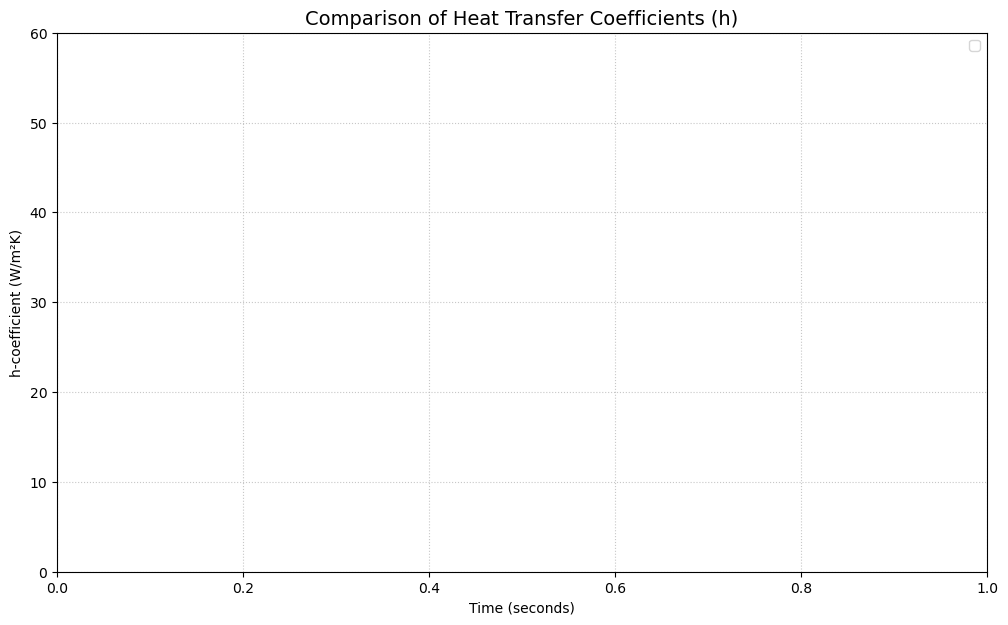

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import os

# --- 1. CONFIGURATION ---
# Use just the filenames if they are in the same folder as this script
files = [
    {"path": "251223_2312_1Hz_2_75WServer10k.csv", "label": "Run 1: 2.75W Server", "offset": 1.2},
    {"path": "251228_2327_2Hz_16w10kfan.csv", "label": "Run 2: 16W Fan", "offset": 1.2},
    {"path": "251229_1926_2Hz_6W_10kFan.csv", "label": "Run 3: 6W Fan", "offset": 1.2},
    {"path": "251230_0004_2Hz_10w_10kFan.csv", "label": "Run 4: 10W Fan", "offset": 1.2}
]

# Physical Constants
n_cells = 5
mc_total = ((n_cells * (47 + 2)) / 1000) * 900  
exposed_factor = 0.90 
total_area = (n_cells * (np.pi * (18/1000) * (55/1000))) * exposed_factor

# Processing Params
sigma_val, window_size, poly_order = 10, 301, 2
results_summary = []

# --- 2. PROCESSING LOOP ---
for run in files:
    if not os.path.exists(run['path']):
        print(f"❌ Skipping {run['path']}: File not found.")
        continue

    df = pd.read_csv(run['path'], names=['time_ms', 'v_thermistor', 'temp_battery', 'temp_ambient', 'v_ups', 'v_battery'], skiprows=1)
    
    # Numeric Conversion
    for col in ['time_ms', 'temp_battery', 'temp_ambient', 'v_battery']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=['time_ms', 'temp_battery']).copy()
    
    # Time and Split
    df['time_sec'] = (df['time_ms'] - df['time_ms'].iloc[0]) / 1000
    split_idx = df['temp_battery'].idxmax()

    # Smoothing & Physics
    df['temp_ambient_corr'] = df['temp_ambient'] + run['offset']
    temp_blurred = gaussian_filter1d(df['temp_battery'], sigma=sigma_val)
    df['temp_bat_smooth'] = savgol_filter(temp_blurred, window_size, poly_order)
    df['dT_dt'] = savgol_filter(temp_blurred, window_size, poly_order, deriv=1, delta=1.0)
    
    df_settle = df.iloc[split_idx:].copy()
    df_settle = df_settle[(df_settle['temp_bat_smooth'] - (df['temp_ambient'] + run['offset'])) > 0.5]
    
    df_settle['delta_T'] = df_settle['temp_bat_smooth'] - (df_settle['temp_ambient'] + run['offset'])
    df_settle['h_coeff'] = -(mc_total * df_settle['dT_dt']) / (total_area * df_settle['delta_T'])
    
    # Median for table
    med_h = df_settle['h_coeff'].median()
    results_summary.append((run['label'], med_h))

    # --- 3. PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(df_settle['time_sec'], df_settle['h_coeff'], color='purple', label='h-coeff')
    ax1.set_ylabel('h-coeff (W/m²K)', color='purple')
    ax1.set_ylim(0, 50)
    ax1.set_title(f"Analysis: {run['label']}")
    plt.grid(True, alpha=0.3)
    plt.show()

# --- 4. PRINT SUMMARY TABLE DATA ---
print("\n" + "="*30)
print("SUMMARY FOR YOUR MARKDOWN TABLE")
print("="*30)
for label, val in results_summary:
    print(f"| {label} | {val:.2f} |")